In [2]:
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Embedding, TimeDistributed, Input 
from tensorflow.keras.models import Sequential
from official.nlp import optimization
import tensorflow as tf
import numpy as np
import pandas as pd

import tensorflow_hub as tf_hub
import tensorflow_text as tf_text

bert_preprocess_layer = tf_hub.KerasLayer('https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3', name='Bert_Preprocessor')
bert_layer = tf_hub.KerasLayer('https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4', name='Bert_Encoder')

## Simple Autoencoder with numbers 

In [ ]:
model = Sequential()
#model.add(Embedding(input_dim=128, output_dim=128))
model.add(LSTM(units=64, activation='relu', input_shape=(4,3), return_sequences=True))
model.add(LSTM(units=32, activation='relu', return_sequences=False))
model.add(RepeatVector(4))
model.add(LSTM(units=32, activation='relu', return_sequences=True))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(3)))

model.compile(optimizer='adam', loss='mse')

# 3 features, 4 timesteps, 4 samples
X = np.array([[[1,2,3], [2,3,4], [3,4,5], [4,5,6]], [[2,3,4], [3,4,5], [4,5,6], [5,6,7]], [[3,4,5], [4,5,6], [5,6,7], [6,7,8]], [[4,5,6], [5,6,7], [6,7,8], [7,8,9]]])
X = X.astype(np.float64)
X = X.reshape(X.shape[0], 4, 3)

model.fit(X, X, batch_size=5, epochs=300, verbose=0)

In [ ]:
print(model.predict(X, verbose=0))

In [ ]:
X_pred = np.array([[[8,9,10], [10,11,12], [11,12,13], [12,13,14]]])
X_pred = X_pred.astype(np.float64)

print(model.predict(X_pred))

## Text Reconstruction
### Experiment 1: Separate Bert Model and Autoencoder
The input to the autoencoder is the bert embedding and the output will also be the bert embedding

Issue: How to generate text from the BERT embedding?

In [3]:
#X = ['Mein', 'Name', 'ist', 'Marco', 'und', 'ich', 'spiele', 'sehr', 'gerne', 'Fussball']
#text_length = 10

input_layer = Input(shape=(), dtype=tf.string, name='Text_Input')
text_preprocessed = bert_preprocess_layer(input_layer)
outputs = bert_layer(text_preprocessed)
embeddings = outputs['sequence_output']

bert_model = tf.keras.Model(input_layer, embeddings)

encoder_input = Input(shape=(128,768), name='Encoder_Input')
lstm1 = LSTM(units=64, activation='relu', return_sequences=True, name='LSTM_Encoder_1')
lstm2 = LSTM(units=32, activation='relu', return_sequences=False, name='LSTM_Encoder_2')
encodings = lstm2(lstm1(encoder_input))

repeat = RepeatVector(128, name='Repeat_Vector')

lstm3 = LSTM(units=32, activation='relu', return_sequences=True, name='LSTM_Decoder_1')
lstm4 = LSTM(units=64, activation='relu', return_sequences=True, name='LSTM_Decoder_2')

decoded = lstm4(lstm3(repeat(encodings)))

tds = TimeDistributed(Dense(768), name='Time_Distributed')
decoder_output = tds(decoded)

text_autoencoder_model = tf.keras.Model(encoder_input, decoder_output)

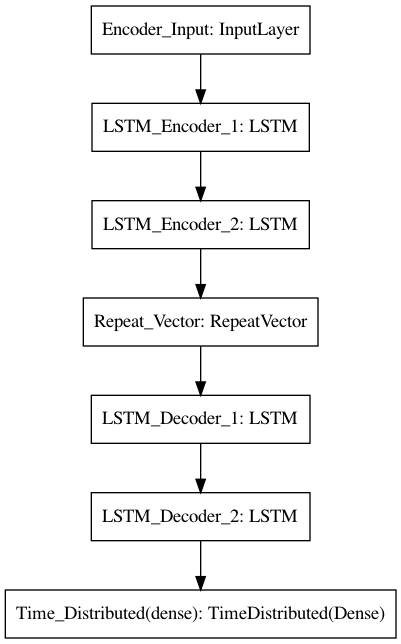

In [4]:
tf.keras.utils.plot_model(text_autoencoder_model)

In [ ]:
text_autoencoder_model.summary()

In [ ]:
sample_text = ['Mein Name ist Marco und ich spiele sehr gerne Fussball']
bert_raw_result = text_autoencoder_model(tf.constant(sample_text))

In [ ]:
bert_raw_result

In [18]:
data = pd.read_csv('../data/export-articles-de-2021-07-15T16:18:00.716875+00:00')
X = data['HEADLINE'].head(5000).to_numpy()

In [19]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 5
steps_per_epoch = X.size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [20]:
text_autoencoder_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [21]:
X_bert = bert_model.predict(X)
history = text_autoencoder_model.fit(x=X_bert, y=X_bert, epochs=epochs)

Epoch 1/5
157/157 [==============================] - 33s 186ms/step - loss: 10.6694 - binary_accuracy: 1.2207e-08
Epoch 2/5
157/157 [==============================] - 30s 192ms/step - loss: 40.1136 - binary_accuracy: 1.2207e-08
Epoch 3/5
157/157 [==============================] - 31s 196ms/step - loss: 1.0601 - binary_accuracy: 1.2207e-08
Epoch 4/5
157/157 [==============================] - 32s 201ms/step - loss: 2.4359 - binary_accuracy: 1.2207e-08
Epoch 5/5
157/157 [==============================] - 31s 200ms/step - loss: 28.4784 - binary_accuracy: 1.2207e-08


In [ ]:
history.history

#### Bert Embedding to Text

In [9]:
embedding_input = Input(shape=(128, 768), name='Text_Input')
flatten = tf.keras.layers.Flatten()
dense = Dense(1)
output = flatten(dense(embedding_input))

embedding_to_id_model = tf.keras.Model(embedding_input, output)

embedding_to_id_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Text_Input (InputLayer)      [(None, 128, 768)]        0         
_________________________________________________________________
dense_1 (Dense)              (None, 128, 1)            769       
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [24]:
#X = bert_model(X)
X_embedding = text_autoencoder_model.predict(X_bert)

In [25]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 5
steps_per_epoch = X_embedding.size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

embedding_to_id_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)                                      

In [26]:
#X2 = data['HEADLINE'].head(200).to_numpy()
text_preprocessed2 = bert_preprocess_layer(X)
history = embedding_to_id_model.fit(x=X_embedding, y=text_preprocessed2['input_word_ids'], epochs=epochs)

Epoch 1/5
157/157 [==============================] - 1s 5ms/step - loss: -222.3476 - binary_accuracy: 0.7243
Epoch 2/5
157/157 [==============================] - 1s 5ms/step - loss: -222.3477 - binary_accuracy: 0.7243
Epoch 3/5
157/157 [==============================] - 1s 5ms/step - loss: -222.3477 - binary_accuracy: 0.7243
Epoch 4/5
157/157 [==============================] - 1s 5ms/step - loss: -222.3479 - binary_accuracy: 0.7243
Epoch 5/5
157/157 [==============================] - 1s 5ms/step - loss: -222.3479 - binary_accuracy: 0.7243


In [27]:
predicted_word_ids = embedding_to_id_model.predict(X_embedding)

In [29]:
predicted_word_ids[0]

array([-0.00093012,  0.00316577,  0.00869279,  0.0151987 ,  0.02233922,
        0.02985169,  0.03749871,  0.04507828,  0.05242255,  0.05940898,
        0.06595587,  0.07201568,  0.07759669,  0.08269048,  0.08729706,
        0.09141051,  0.09504964,  0.0982489 ,  0.10104781,  0.10348716,
        0.10560644,  0.10744295,  0.10903103,  0.11040135,  0.11158183,
        0.11259688,  0.11346814,  0.11421464,  0.11485314,  0.11539803,
        0.11586217,  0.11625608,  0.11658903,  0.11686952,  0.11710551,
        0.11730341,  0.11746892,  0.11760685,  0.11772145,  0.11781622,
        0.11789424,  0.11795809,  0.11801004,  0.1180521 ,  0.11808579,
        0.11811254,  0.11813355,  0.11814982,  0.11816222,  0.11817154,
        0.11817822,  0.11818285,  0.11818589,  0.11818757,  0.11818838,
        0.1181884 ,  0.11818784,  0.1181869 ,  0.11818564,  0.11818425,
        0.11818277,  0.11818124,  0.11817976,  0.11817826,  0.11817691,
        0.11817554,  0.11817434,  0.1181733 ,  0.11817221,  0.11

In [23]:
num_train_steps

25000

In [17]:
text_preprocessed2['input_word_ids'][0]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101, 10808,   118, 24571, 31156, 10633,   131, 12004, 72441,
         123, 10298,  1725, 12240, 62932, 95797, 10107, 29606,   100,
         100,   118,   160, 68999, 11090,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   